<h1> Create Simple Graph

In [9]:
from typing import Dict, Any, TypedDict
from langgraph.graph import Graph, StateGraph

In [14]:
# Create an agent greeting function

class AgentState(TypedDict):
    message: str


def greeting_node(state: AgentState) -> AgentState:
    """ Simple greeting node for the agent. """
    state['message'] = "Hello! " + state['message'] + " How can I assist you today?"
    
    return state

In [15]:
graph = StateGraph(AgentState) # Create a state graph with the defined state type

graph.add_node("greeter", greeting_node) # Two arguments: node name and function

graph.set_entry_point("greeter") # Set the entry point of the graph use the node name
graph.set_finish_point("greeter") # Set the finish point of the graph use the node name

app = graph.compile() # Compile the graph

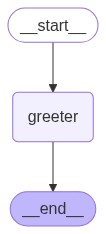

In [12]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
result = app.invoke({"message": "Prada,"})

In [18]:
result['message']

'Hello! Prada, How can I assist you today?'

# Exercise 1
 create a Personalized Compliment Agent using LangGraph!
  
 `Hint: You have to concanate the state, not replace it`

In [20]:
class ComplimentState(TypedDict):
    message: str
    
def compliment_node(state: ComplimentState) -> ComplimentState:
    """ Simple compliment node for the agent. """
    state['message'] = state['message'] + " You are doing a great job!"
    
    return state


In [21]:
graph = StateGraph(ComplimentState) # Create a state graph with the defined state type

graph.add_node("compliment", compliment_node) # Two arguments: node name and function
graph.set_entry_point("compliment") # Set the entry point of the graph use the node name
graph.set_finish_point("compliment") # Set the finish point of the graph use the node name

app = graph.compile() # Compile the graph

In [22]:
result = app.invoke({"message": "Prada,"})
result['message']

'Prada, You are doing a great job!'

In [94]:
import os
from typing import Dict, Any
from dotenv import load_dotenv
import pandas as pd

from langgraph.graph import Graph, START, END
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage

# Load environment variables
load_dotenv()

class SummaryReport:
    def __init__(self):
        self.llm = ChatOpenAI(
            model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"),
            temperature=0.1  # Low temperature for consistent results
        )
        self.data_path = os.getenv("DATA_PATH", "data/11_Final_Report_Credit_Usage.csv")
    
    def data_collector(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """Collect Data from CSV file."""
        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"Data file not found at {self.data_path}")
        
        try:
            df = pd.read_csv(self.data_path)
        except Exception as e:
            raise ValueError(f"Error reading CSV file: {e}")

        print(f"Data loaded with {len(df)} records.")
        state['data'] = df
        return state
    
    def calculate_utilization(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """Calculate Credit Utilization."""
        df = state['data']
        # Group by
        Credit_utilization = df.groupby('Package Status (Today)').agg({
            'Remaining Credits (Today)': 'sum',
            'Initial Credits': 'sum'
        })
        Credit_utilization['Utilization Rate'] = (Credit_utilization['Remaining Credits (Today)'] / Credit_utilization['Initial Credits'] * 100).round(2)
        state['utilization'] = Credit_utilization.to_dict()
        return state
    
    def generate_report_agent(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """Generate Summary Report using LLM."""
        utilization = state['utilization']

        # Ubah DataFrame ke teks agar bisa dibaca oleh LLM
        utilization_text = utilization
        prompt = f"""
        Based on the following credit utilization data:
        {utilization_text}
        
        Please provide a summary report highlighting key insights and recommendations.
        """

        # Gunakan .invoke() untuk menghasilkan output langsung dari ChatOpenAI
        response = self.llm.invoke([HumanMessage(content=prompt)])

        # Ambil teks hasil dari model
        state['report'] = response.content
        print("✅ Report generated successfully.")
        return state


In [95]:
# Pastikan sudah import semua dependensi
from dotenv import load_dotenv
import pandas as pd

# Panggil fungsi load_dotenv untuk baca .env
load_dotenv()

# Import kelas SummaryReport (pastikan sudah didefinisikan di atas)
report = SummaryReport()

# Buat state awal (kosong)
state = {}

# Jalankan fungsi data_collector
state = report.data_collector(state)
state = report.calculate_utilization(state)
state = report.generate_report_agent(state)

state['report']

Data loaded with 83866 records.


2025-11-12 16:10:43,480 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ Report generated successfully.


'### Summary Report on Credit Utilization\n\n#### Overview\nThis report analyzes the current credit utilization data, focusing on both active and expired credits. The data provides insights into the remaining credits, initial credits, and utilization rates for both categories.\n\n#### Key Insights\n\n1. **Remaining Credits**:\n   - **Active Credits**: $19,085\n   - **Expired Credits**: $81,058\n   - The total remaining credits amount to $100,143, with a significant portion being expired credits.\n\n2. **Initial Credits**:\n   - **Active Credits**: $32,245\n   - **Expired Credits**: $222,702\n   - The initial credits indicate a substantial amount of credits that were available but have since expired.\n\n3. **Utilization Rates**:\n   - **Active Utilization Rate**: 59.19%\n     - This indicates that a little over half of the active credits have been utilized, suggesting a moderate level of engagement with the available credits.\n   - **Expired Utilization Rate**: 36.4%\n     - A lower uti

In [96]:
report_text = state['report']

with open("summary_report.md", "w", encoding="utf-8") as f:
    f.write("# Credit Utilization Summary Report\n\n")
    f.write(report_text)


In [60]:
utilization = state['utilization']

# Ubah DataFrame ke teks agar bisa dibaca oleh LLM
utilization_text = utilization

utilization_text

{'Remaining Credits (Today)': {'Active': 19085.0, 'Expired': 81058.0},
 'Initial Credits': {'Active': 32245.0, 'Expired': 222702.0},
 'Utilization Rate': {'Active': 59.19, 'Expired': 36.4}}

In [35]:
data = pd.read_csv(os.getenv("DATA_PATH", "data/11_Final_Report_Credit_Usage.csv"))
data.head()

,Client name,Email,Area,ID,Plan,Transaction Amount,Transaction Date,Last Event Date,Expired Date,Remaining Credits (Today),Package Status (Today),Snapshot Date,Days Since Last Event,Initial Credits,Amount per Credit,Remaining Value
0,Tes Clienr,gus.suryawibawa@gmail.com,Bali,50,12 Classes Pass,0.0,2022-04-28,2022-04-28,2023-04-28,12.0,Expired,2025-11-11,1293,12.0,0.0,0.0
1,Tes Clienr,gus.suryawibawa@gmail.com,Bali,81,Self Training (1 Month),0.0,2022-04-28,2022-04-28,2022-05-28,100.0,Expired,2025-11-11,1293,100.0,0.0,0.0
2,Tes Clienr,gus.suryawibawa@gmail.com,Bali,50,12 Classes Pass,1200000.0,2022-05-05,2022-05-05,2023-05-05,12.0,Expired,2025-11-11,1286,12.0,100000.0,1200000.0
3,Tes Clienr,gus.suryawibawa@gmail.com,Bali,81,Self Training (1 Month),650000.0,2022-05-05,2022-05-05,2022-06-05,100.0,Expired,2025-11-11,1286,100.0,6500.0,650000.0
4,Tes Clienr,gus.suryawibawa@gmail.com,Bali,82,ZINFIT Trial,0.0,2022-05-11,2022-05-13,2022-06-11,0.0,Expired,2025-11-11,1278,1.0,0.0,0.0


In [38]:
Credit_utilization = data.groupby('Package Status (Today)').agg({
    'Remaining Credits (Today)': 'sum',
    'Initial Credits': 'sum'
})
Credit_utilization['Utilization Rate'] = Credit_utilization['Remaining Credits (Today)'] / Credit_utilization['Initial Credits'] * 100
Credit_utilization

,Remaining Credits (Today),Initial Credits,Utilization Rate
Package Status (Today),,,
Active,19085.0,32245.0,59.187471
Expired,81058.0,222702.0,36.397518


In [63]:
df_att = pd.read_csv(os.getenv("DATA_PATH", "data/Attendance Final.csv"))
df_att.shape

(448653, 65)

In [64]:
df_att_attended = df_att[df_att['Attended'] == 'Yes']
df_att_attended.shape

(420914, 65)

In [72]:
import datetime
from dateutil.relativedelta import relativedelta

# Ambil tanggal hari ini
today = datetime.date.today()

# Bulan dan tahun saat ini
current_month = today.month
current_year = today.year

# Awal bulan ini
current_start = datetime.date(current_year, current_month, 1)

# Akhir bulan ini (hari ini)
current_end = today

# Bulan lalu
previous_month_date = current_start - relativedelta(months=1)
previous_year = previous_month_date.year
previous_month = previous_month_date.month

# Awal dan akhir bulan lalu (sampai tanggal hari ini, bukan akhir bulan)
previous_start = datetime.date(previous_year, previous_month, 1)
previous_end = previous_start + datetime.timedelta(days=today.day - 1)

# Cetak hasil
print(f"📅 Current Month Range: {current_start} to {current_end}")
print(f"📅 Previous Month Range: {previous_start} to {previous_end}")


📅 Current Month Range: 2025-11-01 to 2025-11-12
📅 Previous Month Range: 2025-10-01 to 2025-10-12


In [75]:
# Filter Dataframe berdasarkan current_start dan current_end serta previous_start dan previous_end
df_current = df_att_attended[(pd.to_datetime(df_att_attended['Date']) >= pd.to_datetime(current_start)) & (pd.to_datetime(df_att_attended['Date']) <= pd.to_datetime(current_end))]
df_previous = df_att_attended[(pd.to_datetime(df_att_attended['Date']) >= pd.to_datetime(previous_start)) & (pd.to_datetime(df_att_attended['Date']) <= pd.to_datetime(previous_end))]

df_concat = pd.concat([df_current, df_previous])

df_concat['year_month'] = pd.to_datetime(df_concat['Date']).dt.to_period('M')

df_concat

,Date,Time,Class Name,Studio,Area,Type,Trainer name,Event name,Client name,Email,...,Month Since Last Fee,Quarter Since Last Fee,Same Level,Non Teach Class,Category Tier,Date of Birth,Age,Studio Visit Category,Data Category,year_month
439381,2025-11-01,08:00,REFORMER,Canggu,Bali,Class,Laura Gargan,Pro-Former,Desirée Dupuis,5754ac38130248438d4b3a1ab4563c79,...,0,0.0,Not Passed,0.0,Tier 2,1900-01-01,125.0,Single Studios Visit,Attendance,2025-11
439382,2025-11-01,08:00,REFORMER,Canggu,Bali,Class,Laura Gargan,Pro-Former,Femke Sophia Van Leeuwen,e2579ce34fe04afcaec199666c97baad,...,0,0.0,Not Passed,0.0,Tier 2,1900-01-01,125.0,Single Studios Visit,Attendance,2025-11
439383,2025-11-01,08:00,REFORMER,Canggu,Bali,Class,Laura Gargan,Pro-Former,Karolina Edman Lundqvist,72141f5fc8c14569a7b9535e7f440456,...,0,0.0,Not Passed,0.0,Tier 2,1900-01-01,125.0,Single Studios Visit,Attendance,2025-11
439384,2025-11-01,08:00,REFORMER,Canggu,Bali,Class,Laura Gargan,Pro-Former,Susi Demir,4af9fb0dde094484adc22d3fa3afb825,...,0,0.0,Not Passed,0.0,Tier 2,1900-01-01,125.0,Single Studios Visit,Attendance,2025-11
439385,2025-11-01,08:00,REFORMER,Kuningan,Jakarta,Class,Yani Putri,Kuningan - All Levels Reformer,Detha Cs,e6f72ec8b4524aa0b9e13140ba1d4d5e,...,0,0.0,Not Passed,0.0,Tier 1,1900-01-01,125.0,Single Studios Visit,Attendance,2025-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426877,2025-10-12,17:00,REFORMER,Neo Soho,Jakarta,Class,Andre Oktavino,Neo - Stretch-Former,Michael Hanggodo,michael.hanggodo@gmail.com,...,0,0.0,Not Defined,0.0,No Fee,1900-01-01,125.0,-,Attendance,2025-10
426878,2025-10-12,17:00,REFORMER,Neo Soho,Jakarta,Class,Andre Oktavino,Neo - Stretch-Former,Nadia Lim,37daa3e00ee24107b720e6a968b525c1,...,0,0.0,Not Defined,0.0,No Fee,1900-01-01,125.0,-,Attendance,2025-10
426879,2025-10-12,17:00,REFORMER,Neo Soho,Jakarta,Class,Andre Oktavino,Neo - Stretch-Former,Ria Agustiwi,a66effb2c56a424cb5dc480dc0959dc9,...,0,0.0,Not Defined,0.0,No Fee,1900-01-01,125.0,Single Studios Visit,Attendance,2025-10
426880,2025-10-12,17:00,REFORMER,Neo Soho,Jakarta,Class,Andre Oktavino,Neo - Stretch-Former,Terence Judian,8e9530a897b844efba5e81acf964d3ff,...,0,0.0,Not Defined,0.0,No Fee,1900-01-01,125.0,-,Attendance,2025-10


In [82]:
# Calculate attendance rate per month
df_att_summary = df_concat.groupby(['year_month', 'Area','Class Format']).agg({
    'Attendance': 'sum'})
df_att_summary.sort_values(by=["Area", "Class Format", "year_month"], inplace=True)
df_att_summary["Attendance Growth (%)"] = df_att_summary.groupby(
    ["Area", "Class Format"]
)["Attendance"].pct_change() * 100

df_att_summary

,,,Attendance,Attendance Growth (%)
year_month,Area,Class Format,,
2025-10,Bali,REFORMER,654.0,NaN
2025-11,Bali,REFORMER,407.0,-37.767584
2025-10,Bali,ZIN FIT,251.0,NaN
2025-11,Bali,ZIN FIT,246.0,-1.992032
2025-10,Bali,ZYCLE,766.0,NaN
2025-11,Bali,ZYCLE,703.0,-8.224543
2025-10,Jakarta,REFORMER,3486.0,NaN
2025-11,Jakarta,REFORMER,2682.0,-23.063683
2025-10,Jakarta,ZIN FIT,60.0,NaN


In [88]:
import os
from typing import Dict, Any
from dotenv import load_dotenv
import pandas as pd

from langgraph.graph import Graph, START, END
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
import datetime
from dateutil.relativedelta import relativedelta

# Load environment variables
load_dotenv()

class SummaryReport:
    def __init__(self):
        self.llm = ChatOpenAI(
            model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"),
            temperature=0.1  # Low temperature for consistent results
        )
        self.data_path = os.getenv("DATA_PATH_ATTENDANCE", "data/Attendance Final.csv")
    
    def data_collector(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """Collect Data from CSV file."""
        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"Data file not found at {self.data_path}")
        
        try:
            df = pd.read_csv(self.data_path)
        except Exception as e:
            raise ValueError(f"Error reading CSV file: {e}")

        print(f"Data loaded with {len(df)} records.")
        state['data'] = df
        return state
    
    def filter_attended(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """Filter attended records."""
        # Initiate Date Ranges
        # Ambil tanggal hari ini
        df = state['data']
        today = datetime.date.today()

        # Bulan dan tahun saat ini
        current_month = today.month
        current_year = today.year

        # Awal bulan ini
        current_start = datetime.date(current_year, current_month, 1)

        # Akhir bulan ini (hari ini)
        current_end = today

        # Bulan lalu
        previous_month_date = current_start - relativedelta(months=1)
        previous_year = previous_month_date.year
        previous_month = previous_month_date.month

        # Awal dan akhir bulan lalu (sampai tanggal hari ini, bukan akhir bulan)
        previous_start = datetime.date(previous_year, previous_month, 1)
        previous_end = previous_start + datetime.timedelta(days=today.day - 1)

        # Cetak hasil
        print(f"📅 Current Month Range: {current_start} to {current_end}")
        print(f"📅 Previous Month Range: {previous_start} to {previous_end}")

        # Filter Dataframe berdasarkan current_start dan current_end serta previous_start dan previous_end
        df_current = df[(pd.to_datetime(df['Date']) >= pd.to_datetime(current_start)) & (pd.to_datetime(df['Date']) <= pd.to_datetime(current_end))]
        df_previous = df[(pd.to_datetime(df['Date']) >= pd.to_datetime(previous_start)) & (pd.to_datetime(df['Date']) <= pd.to_datetime(previous_end))]

        df_concat = pd.concat([df_current, df_previous])

        df_concat['year_month'] = pd.to_datetime(df_concat['Date']).dt.to_period('M')

        # Filter only attended records
        df_attended = df_concat[df_concat['Attended'] == 'Yes']

        state['data_cleaned'] = df_attended
        return state

    def group_attendance(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """Group Attendance Data."""
        df = state['data_cleaned']
        # Calculate attendance rate per month
        df_att_summary = df.groupby(['year_month', 'Area','Class Format']).agg({
            'Attendance': 'sum'})
        df_att_summary.sort_values(by=["Area", "Class Format", "year_month"], inplace=True)
        df_att_summary["Attendance Growth (%)"] = df_att_summary.groupby(
            ["Area", "Class Format"]
        )["Attendance"].pct_change() * 100

        state['attendance_growth_data'] = df_att_summary.to_dict()
        return state    


        
    from langchain.schema import HumanMessage

    def growth_summary_agent(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """
        Generate summary report about attendance growth per area and class format.
        """
        # Ambil data dari state
        attendance_data = state.get('attendance_growth_data', None)
        
        if attendance_data is None:
            raise ValueError("Attendance growth data not found in state.")

        # Prompt untuk LLM
        prompt = f"""
        Kamu adalah analis bisnis studio fitness.

        Berikut data attendance dan growth-nya per bulan, area, dan class format:
        {attendance_data}

        Buatkan ringkasan singkat yang menjelaskan:
        1. Performa pertumbuhan (growth) attendance per class format di setiap area dari bulan sebelumnya ke bulan sekarang.
        2. Sebutkan class format mana yang mengalami penurunan paling besar dan paling kecil di setiap area.
        3. Gunakan bahasa profesional dan ringkas (maksimal 3 kalimat per area).

        Format hasil:
        Area: [Nama Area]
        - [Class Format]: [tren naik/turun] sebesar [persentase growth].
        - Insight singkat.
        """

        # Kirim ke LLM
        response = self.llm.invoke([HumanMessage(content=prompt)])

        # Simpan hasil summary ke state
        state["growth_summary_report"] = response.content

        return state



In [89]:
app = SummaryReport()

state = {}

state = app.data_collector(state)
state = app.filter_attended(state)
state = app.group_attendance(state)
state = app.growth_summary_agent(state)
state['growth_summary_report']

Data loaded with 448653 records.
📅 Current Month Range: 2025-11-01 to 2025-11-12
📅 Previous Month Range: 2025-10-01 to 2025-10-12


2025-11-12 15:54:33,770 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Area: Bali  \n- REFORMER: turun sebesar -37.77%.  \n- ZIN FIT: turun sebesar -1.99%.  \n- ZYCLE: turun sebesar -8.22%.  \nPertumbuhan attendance di Bali menunjukkan penurunan signifikan pada semua class format, dengan REFORMER mengalami penurunan terbesar. Hal ini mungkin menunjukkan kebutuhan untuk evaluasi strategi pemasaran atau penawaran kelas yang lebih menarik.\n\nArea: Jakarta  \n- REFORMER: turun sebesar -23.06%.  \n- ZIN FIT: turun sebesar -46.67%.  \n- ZYCLE: turun sebesar -19.65%.  \nJakarta juga mengalami penurunan di semua class format, dengan ZIN FIT mencatat penurunan paling besar. Penurunan yang tajam ini mengindikasikan perlunya analisis lebih lanjut untuk memahami faktor-faktor yang mempengaruhi minat peserta.'

In [ ]:
with open("attendance_growth_summary_report.txt", "w", encoding="utf-8") as f:
    f.write(state['growth_summary_report'])

print("✅ Report saved to attendance_growth_summary_report.txt")

✅ Report saved to attendance_growth_summary_report.txt


In [91]:
report_text = state['growth_summary_report']

with open("attendance_growth_summary_report.md", "w", encoding="utf-8") as f:
    f.write("# Attendance Summary Report\n\n")
    f.write(report_text)